In [1]:
# import all the libraries
# good practice to keep all libraries in one place

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# the following libraries are all the scripts that we created
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.feature_importance_plot import feature_importance_plot
from src.learning_curve_plot import learning_curve_plot
from src.identify_and_handle_missing_data import identify_missing_data, handle_categorical_missing_data, handle_numerical_missing_data
from src.helpers import identify_number_categories, one_hot, identify_highly_correlated_features, identify_low_variance_features
from src.algorithm_eval import algorithm_eval_regression


### Load the Data

In [2]:
# import the housing data from fetch_openml

housing = fetch_openml(name="house_prices", as_frame=True)  

housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['target'] = housing['target']
housing_df.drop(['Id'], inplace = True, axis = 1)

### Explore the Data - This can be of the most detailed parts of the work we do

In [3]:
# preview the first five rows

pd.set_option('display.max_columns', None)

housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [4]:
# check the shape of the data

housing_df.shape

# We can see we have 1460 rows of data, where each row is the data on a particular house, with 80 potential features.

(1460, 80)

In [5]:
# check the info of the data

housing_df.info()

# this gives me a good overview, but difficult for me to count how many numerical and categorical data types I am working with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   float64
 17  OverallCond    1460 non-null   float64
 18  YearBuil

In [6]:
# identify how many categorical columns of data we have i.e. variables with data type object

categorical_cols = list(housing_df.select_dtypes(['object']).columns)
print("number of categorical columns:", len(categorical_cols))

# We know the machine learning model can not handle categorical columns, so we need to encode these columns when we do our feature engineering

number of categorical columns: 43


In [8]:
# identify how many numerical columns of data we have i.e. variables with data type int, float or bool

numerical_cols = list(housing_df.select_dtypes(['int64', 'float64', 'bool']).columns)
print("number of numerical columns:", len(numerical_cols))

# does 43 + 37 add up to 80? That means, we only have numerical and categorical data. No dates.

number of numerical columns: 37


In [9]:
# look at the summary statistics of all the numerical data
# this gives us a summary of the count, mean, median, 25th and 75th percentile, min , max values and std

housing_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


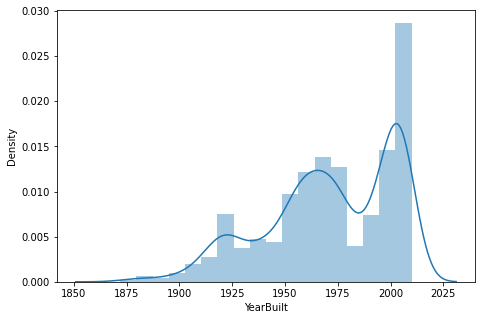

In [10]:
# Lets say we are interested in looking at the distribution of the YearBuilt

plt.rcParams["figure.figsize"] = (7.5, 5)

sns.distplot(housing_df.YearBuilt);

# question: at what year do we see the peak forming?
# diffiult to see from the graph, but we get an idea we have more houses built in 2000s on the market

# question: is the data positively or negatively skewed?

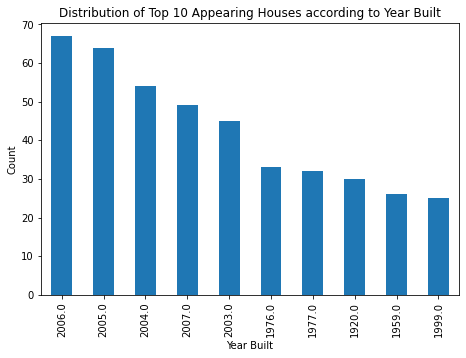

In [15]:
# one way of looking at the data in more detail

housing_df.YearBuilt.value_counts().nlargest(10).plot(kind = 'bar')
plt.title("Distribution of Top 10 Appearing Houses according to Year Built")
plt.xlabel("Year Built")
plt.ylabel("Count");

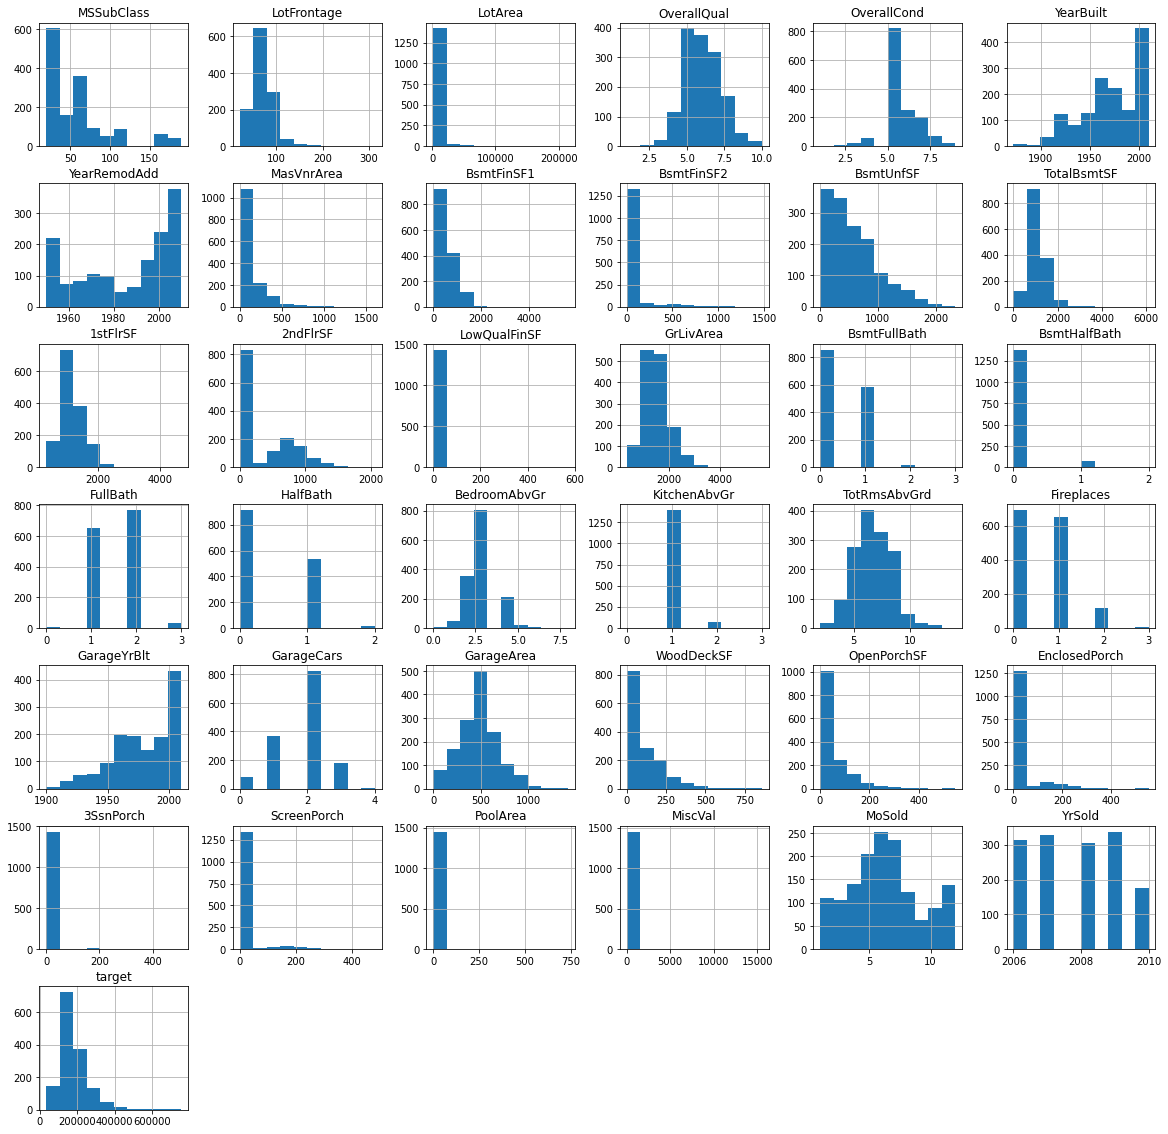

In [11]:
# what if we want to look at the distribution of all numerical data?
# please note this code will not work for boolean variables - you need to drop boolean variables

plt.rcParams["figure.figsize"] = (20,20)

housing_df.hist();

# what can you say about the distribution of all the variables? 
# what can you say about the distribution of the target variable?
# any other features you are interested in?
# You could add a markdown with a summary of your findings.
# Because of the skeweness in the data, we are going to with decision trees and ensemble method models

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


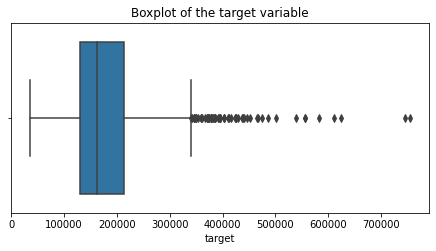

In [18]:
# let's look at the distribution of the target in more detail

plt.rcParams["figure.figsize"] = (7.5, 3.5)

sns.boxplot(housing_df.target)
plt.title("Boxplot of the target variable");

# question: what can you see from the box plot?

**Note**:
- Decision Tree algorithms are not sensitive to outliers, so the removal of outliers is up to the Machine Learning practioner.
- This resource provides a list of algorithms which are sensitive to outliers: https://arsrinevetha.medium.com/ml-algorithms-sensitivity-towards-outliers-f3862a13c94d
- In our feature engineering step, we could remove the outliers.

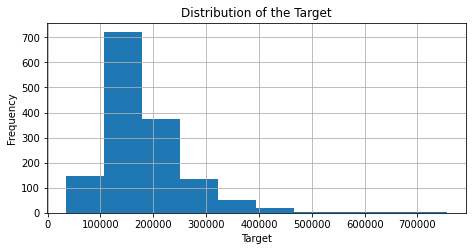

In [19]:
# how would you remove the outliers? 
# check the distribution of the variable (look at the plot above or..)

housing_df.target.hist()
plt.title("Distribution of the Target")
plt.xlabel("Target")
plt.ylabel("Frequency");

# what is the skew of the target variable?

In [20]:
# you can also look at the describe function to identify skew

housing_df.target.describe()

# some slight positive skew - this can be identified with the mode less than the median less than the mean

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: target, dtype: float64

In [21]:
print("mean of the housing_df", round(housing_df.target.mean(), 2))
print("median of the housing_df", round(housing_df.target.median(), 2))
print("mode of the housing_df", list(housing_df.target.mode())[0])

# we can see the mean, median and mode are not equal which implies skew

mean of the housing_df 180921.2
median of the housing_df 163000.0
mode of the housing_df 140000.0


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


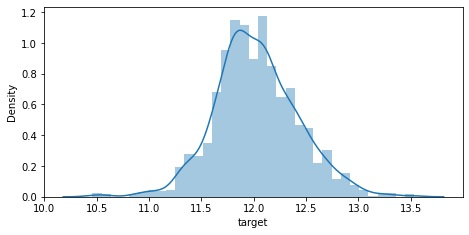

In [22]:
# what would the distribution look like if we transformed the target variable

sns.distplot(np.log(housing_df.target));

# what does the distribution look like now?

In [23]:
# You could also plot the correlations between data points 

corr = housing_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# take a few minutes, can we you see any highly correlated features?
# look at the target column - which fetaures are highly correlated with the target? These could be interesting features.

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.088011,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


### Data Cleaning

In [24]:
# identify and remove any duplicates

housing_df[housing_df.duplicated()]

# Question: Can we see any duplicates?
# no, we do not have to do any removal

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target


### Feature Engineering 

Recall lecture number 3 IP301, these are some of the steps we can take to carry our featue engineering

1. Feature Selection (*)
2. Handling missing values (*)
3. Handling outliers 
4. Feature Scaling and Transformation
5. Binning
6. Encoding (*)


#### Feature Selection

In [32]:
# Identify features with a missing percentage greater than a specified threshold
# use this definition to identify features with high missing values
# we have 80 columns, so feature selection is an extremely important step to reduce the number of columns
     
missing_value_df = identify_missing_data(housing_df)
missing_value_df

,feature,percent_missing,data_type
0,PoolQC,99.52,object
1,MiscFeature,96.30,object
2,Alley,93.77,object
3,Fence,80.75,object
4,FireplaceQu,47.26,object
...,...,...,...
75,Heating,0.00,object
76,HeatingQC,0.00,object
77,MSZoning,0.00,object
78,1stFlrSF,0.00,float64


In [33]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 40

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 5
['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


In [34]:
# drop the features 

housing_df_reduced = housing_df.drop(cols_to_drop, axis = 1)

# check the size of the data
print("shape of data", housing_df.shape)
print("shape of data after feature removal", housing_df_reduced.shape)

shape of data (1460, 80)
shape of data after feature removal (1460, 75)


In [35]:
# Identifies features with a single unique value or very low variance
# look at the standard deviation of all the features

housing_df_reduced.std()

# question: which feature has the lowest standard deviation? 

MSSubClass          42.300571
LotFrontage         24.284752
LotArea           9981.264932
OverallQual          1.382997
OverallCond          1.112799
YearBuilt           30.202904
YearRemodAdd        20.645407
MasVnrArea         181.066207
BsmtFinSF1         456.098091
BsmtFinSF2         161.319273
BsmtUnfSF          441.866955
TotalBsmtSF        438.705324
1stFlrSF           386.587738
2ndFlrSF           436.528436
LowQualFinSF        48.623081
GrLivArea          525.480383
BsmtFullBath         0.518911
BsmtHalfBath         0.238753
FullBath             0.550916
HalfBath             0.502885
BedroomAbvGr         0.815778
KitchenAbvGr         0.220338
TotRmsAbvGrd         1.625393
Fireplaces           0.644666
GarageYrBlt         24.689725
GarageCars           0.747315
GarageArea         213.804841
WoodDeckSF         125.338794
OpenPorchSF         66.256028
EnclosedPorch       61.119149
3SsnPorch           29.317331
ScreenPorch         55.757415
PoolArea            40.177307
MiscVal   

In [36]:
# lets look at the low variance variable in more detail
# small range, and most of the data values are 1

housing_df_reduced.KitchenAbvGr.describe()

count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


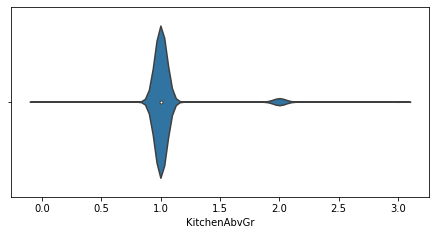

In [37]:
# we could also visualise the data

sns.violinplot(housing_df_reduced.KitchenAbvGr);

In [38]:
def identify_low_variance_features(df, std_threshold):
    """
    This definition can be used to identify features with low varaince
    
    @param df pandas DataFrame
    @param std_threshold int 
    
    @return a list of features that have low variance
    """
    
    std_df = pd.DataFrame(df.std()).rename(columns = {0: 'standard_deviation'})

    low_var_features = list(std_df[std_df['standard_deviation'] < std_threshold].index)

    print("number of low variance features:", len(low_var_features))
    print("low variance features:", low_var_features)
    
    return low_var_features

In [39]:
# identify features that have standard deviation less than 0.5

std_threshold = 0.5

low_var_features = identify_low_variance_features(housing_df_reduced, std_threshold)


number of low variance features: 2
low variance features: ['BsmtHalfBath', 'KitchenAbvGr']


In [40]:
# drop low_var_features

housing_df_reduced.drop(low_var_features, axis = 1, inplace = True)
print("shape of data after feature removal", housing_df_reduced.shape)

shape of data after feature removal (1460, 73)


In [41]:
def identify_highly_correlated_features(df, correlation_threshold):
    """
    This definition can be used to identify highly correlated features
    
    @param df pandas DataFrame
    @param correlation_threshold int 
    
    @return a DataFrame with highly correlated features 
    """
    
    corr_matrix = df.corr().abs() # calculate the correlation matrix with 
    high_corr_var = np.where(corr_matrix >= correlation_threshold) # identify variables that have correlations above defined threshold
    high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], round(corr_matrix.iloc[x, y], 2))
                         for x, y in zip(*high_corr_var) if x != y and x < y] # identify pairs of highly correlated variables
    
    high_corr_var_df = pd.DataFrame(high_corr_var).rename(columns = {0: 'corr_feature',
                                                                     1: 'drop_feature',
                                                                     2: 'corrrelation_values'})

    return high_corr_var_df.sort_values(by = 'corrrelation_values', ascending = False)


In [42]:
# identify and remove highly correlated features

corr_df = identify_highly_correlated_features(housing_df_reduced, correlation_threshold = 0.8)
corr_df

# does this match what you saw in the correlation plot above?
# look at this table, decide which features you want to drop.

,corr_feature,drop_feature,corrrelation_values
3,GarageCars,GarageArea,0.88
0,YearBuilt,GarageYrBlt,0.83
2,GrLivArea,TotRmsAbvGrd,0.83
1,TotalBsmtSF,1stFlrSF,0.82


In [45]:
# look at the table, and drop all features in the drop_feature column

cols_to_drop = np.unique(corr_df.drop_feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 4
['1stFlrSF' 'GarageArea' 'GarageYrBlt' 'TotRmsAbvGrd']


In [46]:
# drop the correlated features

housing_df_reduced = housing_df_reduced.drop(columns=corr_df.drop_feature)

# check shape of new dataframe
print("shape of data after feature removal", housing_df_reduced.shape)

shape of data after feature removal (1460, 69)


In [47]:
# we need to encode the categorical data before moving forward
# check how many categories each categorical variable has

cat_df = identify_number_categories(housing_df_reduced)
cat_df

,categorical_feature,number_categories
7,Neighborhood,25
15,Exterior2nd,16
14,Exterior1st,15
8,Condition1,9
36,SaleType,9
9,Condition2,8
13,RoofMatl,8
11,HouseStyle,8
24,BsmtFinType2,7
23,BsmtFinType1,7


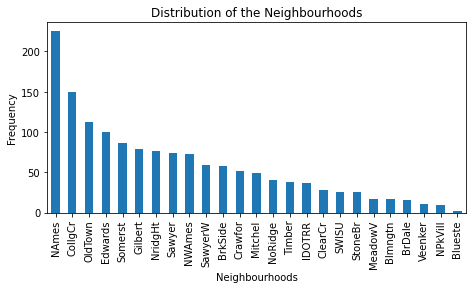

In [48]:
# look at the distribution of the categorical data

housing_df_reduced.Neighborhood.value_counts().plot(kind = 'bar')
plt.title("Distribution of the Neighbourhoods")
plt.xlabel("Neighbourhoods")
plt.ylabel("Frequency");

In [49]:
# Because of the size of the data, drop categorical features with more than 5 categories

threshold = 5

features_to_drop = list(cat_df[cat_df.number_categories > threshold].categorical_feature)
print("number of features to drop:", len(features_to_drop))

number of features to drop: 19


In [50]:
features_to_drop

['Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'Condition1',
 'SaleType',
 'Condition2',
 'RoofMatl',
 'HouseStyle',
 'BsmtFinType2',
 'BsmtFinType1',
 'Functional',
 'GarageType',
 'Electrical',
 'Heating',
 'GarageQual',
 'GarageCond',
 'Foundation',
 'SaleCondition',
 'RoofStyle']

In [54]:
# drop the features

housing_df_reduced = housing_df_reduced.drop(features_to_drop, axis = 1)

# check shape of the reduce dataset
print("shape of data after feature removal", housing_df_reduced.shape)

shape of data after feature removal (1460, 50)


#### Handling Missing Data

In [55]:
# Handling missing data
# lets check what is left

missing_value_df = identify_missing_data(housing_df_reduced)
missing_value_df[missing_value_df.percent_missing > 0] # only look at features where percent_missing greater than 0

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageFinish,5.55,object
2,BsmtExposure,2.60,object
3,BsmtCond,2.53,object
4,BsmtQual,2.53,object
5,MasVnrType,0.55,object
6,MasVnrArea,0.55,float64


In [56]:
# replace all categorical (data type object) missing values with Unknown
# you can use these new definitions to handle categorical data

handle_categorical_missing_data(housing_df_reduced)

number of categorical cols with missing data: 5
replacing missing values for: GarageFinish
replacing missing values for: BsmtExposure
replacing missing values for: BsmtCond
replacing missing values for: BsmtQual
replacing missing values for: MasVnrType


In [57]:
# replace all numerical missing (data type int, float or bool) values with 0
# you can use these new definitions to handle categorical data

handle_numerical_missing_data(housing_df_reduced, fill_na_value=0)

number of numerical cols with missing data: 2
replacing missing values for: LotFrontage
replacing missing values for: MasVnrArea


In [58]:
# check do we have any missing data left

missing_value_df = identify_missing_data(housing_df_reduced)
missing_value_df

# no missing data left, we can continue moving forward

,feature,percent_missing,data_type
0,MSSubClass,0.0,float64
1,GarageFinish,0.0,object
2,CentralAir,0.0,object
3,2ndFlrSF,0.0,float64
4,LowQualFinSF,0.0,float64
5,GrLivArea,0.0,float64
6,BsmtFullBath,0.0,float64
7,FullBath,0.0,float64
8,HalfBath,0.0,float64
9,BedroomAbvGr,0.0,float64


#### Encoding the categorical data

In [59]:
# encode all the categorical data
# you can use the definition we created which takes the categorical data and encodes them

categorical_columns = list(housing_df_reduced.select_dtypes(['object']).columns) # identify all the categorical columns

housing_df_reduced_w_encoding = one_hot(housing_df_reduced, categorical_columns)

# shape of the new dataframe
print("shape of the new data frame", housing_df_reduced_w_encoding.shape)

shape of the new data frame (1460, 108)


### Building the Machine Learning Model

In [60]:
# check the info - do we have any categorical data left?
# we should only have floats and uint. 

housing_df_reduced_w_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 108 entries, MSSubClass to PavedDrive_Y
dtypes: float64(31), uint8(77)
memory usage: 463.5 KB


In [62]:
housing_df_reduced_w_encoding.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unknown,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unknown,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unknown,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unknown,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Unknown,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,854.0,0.0,1710.0,1.0,2.0,1.0,3.0,0.0,2.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,0.0,0.0,1262.0,0.0,2.0,0.0,3.0,1.0,2.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,866.0,0.0,1786.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,756.0,0.0,1717.0,1.0,1.0,0.0,3.0,1.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1053.0,0.0,2198.0,1.0,2.0,1.0,4.0,1.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1


In [63]:
# have a look at a random categorical variables

housing_df_reduced.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [64]:
print(housing_df_reduced_w_encoding.PavedDrive_Y.sum())
print(housing_df_reduced_w_encoding.PavedDrive_N.sum())
print(housing_df_reduced_w_encoding.PavedDrive_P.sum())

1340
90
30


In [43]:
# define the target and features

target = housing_df_reduced_w_encoding["target"]
features = housing_df_reduced_w_encoding.drop(["target"], axis = 1)

In [44]:
target.shape

(1460,)

In [45]:
features.shape

(1460, 107)

In [46]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.3, 
                                                random_state = 8)


In [47]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (1022, 107)
Shape of y_train (1022,)


In [48]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (438, 107)
Shape of y_test (438,)


### Model Selection 

In [49]:
from sklearn.dummy import DummyRegressor

# model selection
models = []

# using Dummy Classifier as a baseline algorithm
models.append(('Dummy Regressor', DummyRegressor()))

# Ride Regression
models.append(('Decision Tree', DecisionTreeRegressor()))

# Random Forest model
models.append(('Random Forest', RandomForestRegressor()))

# XGBoost
models.append(('XGBoost', XGBRegressor()))

In [50]:
scoring_df = algorithm_eval_regression(models, X_train, y_train, X_test, y_test)
scoring_df.sort_values(by = "R2", ascending = False)

,Model Name,R2,Explained Variance,Mean Absolute Error,Mean Squared Error
2,Random Forest,0.8347,0.8371,17334.3758,8.756044e+08
3,XGBoost,0.7551,0.7595,19727.4810,1.297117e+09
1,Decision Tree,0.7083,0.7116,24813.1027,1.544780e+09
0,Dummy Regressor,-0.0035,0.0000,54738.2571,5.314725e+09


The Random Forest Model is the best model in terms of evalation metrics, has the highest R2, and also the lowest MAE and MSE.

### Best Model Evaluation

In [51]:
# Build a Random Forest Model

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [52]:
print("first five predicted values:", y_pred_rf[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [185573.85 127464.33 125093.04 142059.39 207493.75]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


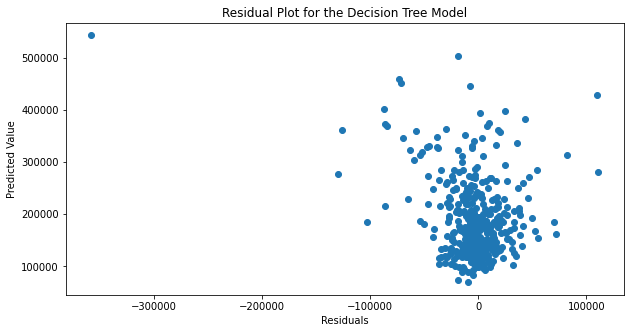

In [53]:
# residual plot - this s a way to look at where the errors are coming from

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_rf

plt.scatter(residuals, y_pred_rf)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [54]:
# the evaluation metrics for the model on the test set


r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))

R2: 0.82
Explained Variance: 0.82
Mean Absolute Error: 17753
Mean Squared Error: 949436818


In [55]:
# the evaluation metrics for the model on the training set
# this is useful for identifying overfitting

y_pred_train_rf = rf.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set and a close to perfect R2 on the training set - signs of overfitting

R2: 0.98
Explained Variance: 0.98
Mean Absolute Error: 6728
Mean Squared Error: 139534276


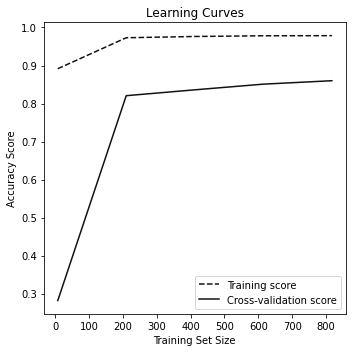

In [56]:
# learning curves

learning_curve_plot(rf, X_train, y_train, scoring = 'r2')

# what can we conclude about the random forest model based on the learning curves?  signs of overfitting and high variance
# unusual shape of the learning curve

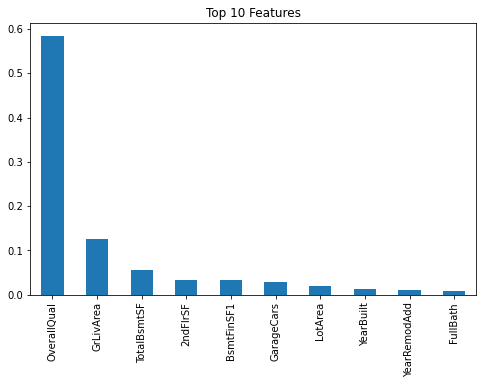

In [58]:
# feature importance plot

feature_importance_plot(rf, X_train, n = 10)

In [59]:
# what are the top 20 lowest features

feat_importances = pd.Series(rf.feature_importances_,
                                 index = X_train.columns)
feat_importance_df = pd.DataFrame(feat_importances).sort_values(by = 0).reset_index().rename(columns = {'index': 'feature',
                                                                                        0: 'score'})
feat_importance_df.head(20)


,feature,score
0,ExterCond_Po,0.000000e+00
1,Utilities_AllPub,2.244009e-08
2,Utilities_NoSeWa,2.782666e-08
3,LotConfig_FR3,4.157229e-07
4,HeatingQC_Po,9.981261e-07
5,BsmtCond_Po,2.227533e-06
6,ExterCond_Ex,3.168431e-06
7,MasVnrType_BrkCmn,3.751243e-06
8,Street_Grvl,4.547880e-06
9,BsmtQual_Unknown,7.806278e-06


In [60]:
# Homework, can you remove the features with the lowest score? Say less than 0.5

Summary
- Looked at a dataset with 1460 rows, and 80 features
- After feature engineering, we removed XX features and encoded all the categorical features to have a final dataset of XX features
- We selected three machine learning algorithms, predominantly decision tree based because of the distribution of the data. 
- The Random Forest Model slightly outperformed the other models in terms of performance metrics (had the highest r2 and lowest MSE, MAE)
- However, when looking at the model in more detail, we saw signs of overfitting and signs of high variance, which was clear from the gap in the learning curves and the differences in metrics on the training and test set. This means the model is just memorising the data, and we can not trust it to generalise well to new data. 
- Next steps would include removing redundant features and seeing if that shows any signs of improvements, and also some hyperparameter tuning. 
